# Task 3: Credit risk analysis

You have now moved to a new team assisting the retail banking arm, which has been experiencing higher-than-expected default rates on personal loans. Loans are an important source of revenue for banks, but they are also associated with the risk that borrowers may default on their loans. A default occurs when a borrower stops making the required payments on a debt.

The risk team has begun to look at the existing book of loans to see if more defaults should be expected in the future and, if so, what the expected loss will be. They have collected data on customers and now want to build a predictive model that can estimate the probability of default based on customer characteristics. A better estimate of the number of customers defaulting on their loan obligations will allow us to set aside sufficient capital to absorb that loss. They have decided to work with you in the QR team to help predict the possible losses due to the loans that would potentially default in the next year.

Charlie, an associate in the risk team, who has been introducing you to the business area, sends you a small sample of their loan book and asks if you can try building a prototype predictive model, which she can then test and incorporate into their loss allowances.

The risk manager has collected data on the loan borrowers. The data is in tabular format, with each row providing details of the borrower, including their income, total loans outstanding, and a few other metrics. There is also a column indicating if the borrower has previously defaulted on a loan. You must use this data to build a model that, given details for any loan described above, will predict the probability that the borrower will default (also known as PD: the probability of default). Use the provided data to train a function that will estimate the probability of default for a borrower. Assuming a recovery rate of 10%, this can be used to give the expected loss on a loan.

- You should produce a function that can take in the properties of a loan and output the expected loss.
- You can explore any technique ranging from a simple regression or a decision tree to something more advanced. You can also use multiple methods and provide a comparative analysis.


# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Read Data

In [5]:
df = pd.read_csv("./Loan_Data.csv")

In [6]:
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


# Data Summary and Description

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


In [9]:
df.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


# Data Preprocessing

In [11]:
# Checking for missing values
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64


# Feature Engineering

In [13]:
# Creating a new feature: Debt-to-Income Ratio
df['debt_to_income'] = df['total_debt_outstanding'] / df['income']

In [14]:
# Calculate the payment_to_income ratio
df['payment_to_income'] = df['loan_amt_outstanding'] / df['income']

In [15]:
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,debt_to_income,payment_to_income
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,0.050173,0.066909
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,0.308789,0.073510
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,0.030787,0.051058
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,0.033645,0.064105
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,0.075435,0.057395


# Train-Test Split

In [17]:
# Splitting into features and target
X = df.drop(columns=['customer_id', 'default'])
y = df['default']

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
# Standardizing numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Visualization

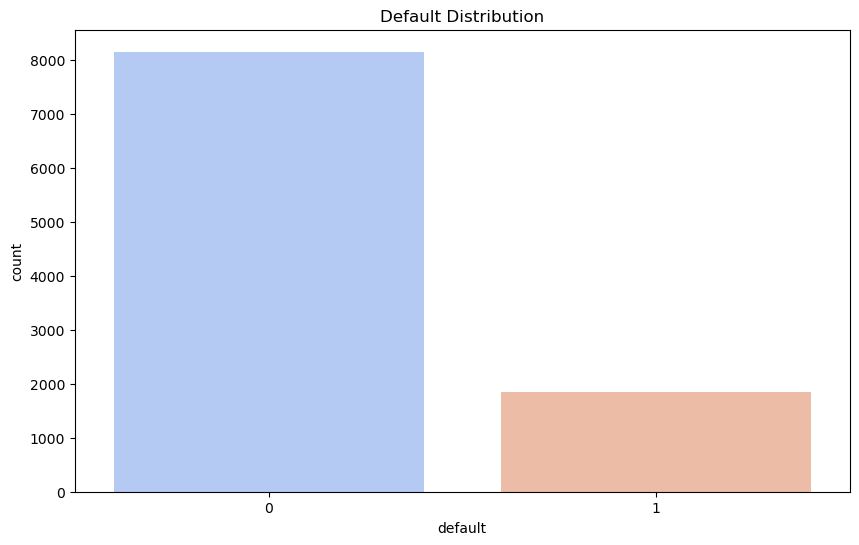

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(x='default', data=df, palette='coolwarm')
plt.title("Default Distribution")
plt.show()

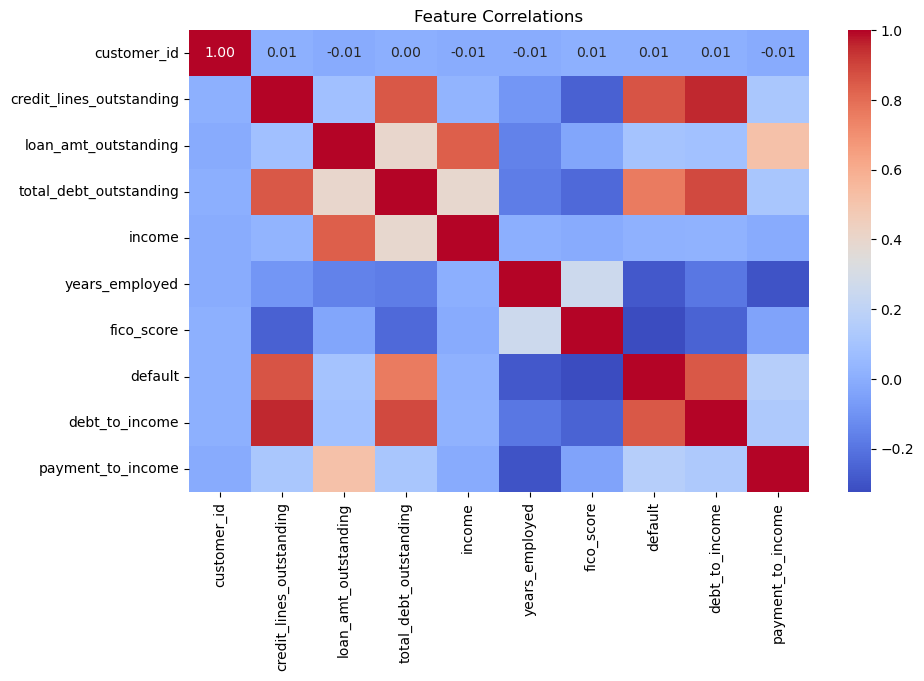

In [22]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlations")
plt.show()

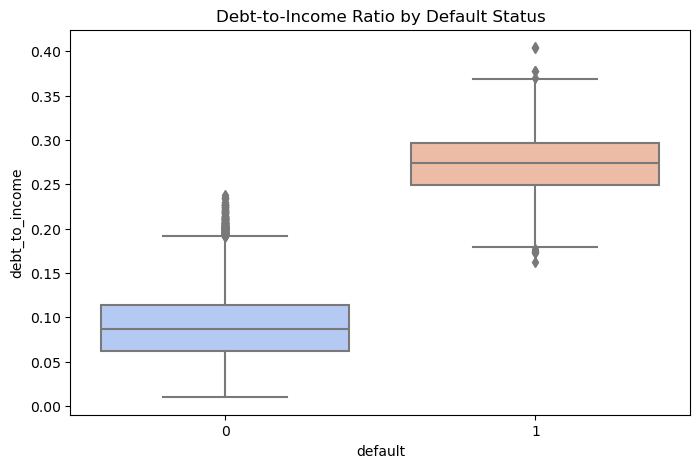

In [23]:
# Boxplot of debt-to-income ratio by default status
plt.figure(figsize=(8, 5))
sns.boxplot(x='default', y='debt_to_income', data=df, palette='coolwarm')
plt.title("Debt-to-Income Ratio by Default Status")
plt.show()

# Model Selection and Training

In [25]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

In [ ]:
best_model = None
best_auc = 0

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    print("\n")
    print(f"{name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("AUC-ROC:", auc)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("-" * 50)
    
    if auc > best_auc:
        best_auc = auc
        best_model = model

print("\n")
print("Best model selected based on AUC-ROC: ", best_model)

# Probability of Default (PD) and Expected Loss Calculation

In [ ]:
def expected_loss(model, scaler, loan_features, loan_amount, recovery_rate=0.1):
    """Calculate expected loss for a given loan."""
    loan_features_scaled = scaler.transform([loan_features])
    pd = model.predict_proba(loan_features_scaled)[:, 1][0]
    loss_given_default = 1 - recovery_rate
    expected_loss_value = loan_amount * pd * loss_given_default
    return expected_loss_value

In [ ]:
# Customer_Id: 8153374
# loan_example = [credit_lines_outstanding, loan_amt_outstanding, total_debt_outstanding, income, years_employed, fico_score, debt_to_income, payment_to_income]
loan_example = [0, 5221.545193, 3915.471226, 78039.38546, 5, 605, 0.050173, 0.066909]
loan_amt = 50000
loss = expected_loss(best_model, scaler, loan_example, loan_amt)
print("Expected Loss:", loss)